In [1]:
# reload modules if needed
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from notebook_utils import get_distribution_over_vocabulary, get_mlm_results, get_downstream_results
from notebook_utils import corpus_sizes

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
FIGURE_DIR = "/home/limisiewicz/my-luster/entangled-in-scripts/output/figures"
TABLE_DIR =  "/home/limisiewicz/my-luster/entangled-in-scripts/output/tables"

In [5]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']

# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 26
plt.rcParams['axes.labelsize'] = 26
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.titlesize'] = 26
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18


## Parameteres

In [6]:
name_map = {
    '20l-multilingual': 'Unigram',
    '20l-bpe': 'BPE',
    '20l-merged': 'TokMix'
}

In [7]:
languages = ("ar", "tr", "zh", "el", "es", "en", "sw", "hi", "mr", "ur", "ta", "te", "th", "ru", "bg", "he", "ka", "vi", "fr", "de")
languages_pos = ("ar", "tr", "zh", "el", "es", "en", "hi", "mr", "ur", "ta", "te", "ru", "bg", "he", "vi", "fr", "de")
languages_xnli = ("ar", "tr", "zh", "el", "es", "en", "vi", "hi", "th", "ru", "bg","fr", "de")
alpha = 0.25
tokenization_types = ('20l-multilingual', '20l-merged', '20l-bpe')
N_vocab = 120000


ft_type = 'PROBE'

In [8]:
in_lang_results = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['All'] )
in_lang_stds = pd.DataFrame(columns=['task', 'metric', 'tokenizer'] + list(languages) + ['All'] )

# Tokenizers and Distributions over Vocabulary

In [9]:
vocab_distributions = dict()
vocab_dist_arrays = dict()
vocab_frequencies = dict()

for tok_type in tokenization_types:
    vocab_distributions[tok_type], vocab_frequencies[tok_type] \
        = get_distribution_over_vocabulary(tok_type, alpha, N_vocab, languages)
    vocab_dist_arrays[tok_type] = {lang: np.array(list(vocab_distributions[tok_type][lang].values()))
                                   for lang in languages + ('All',)}

## Probability Distribution Function
The tokens are sorted by frequency

In [10]:
def boxplot_across_languages(res, metric, languages, task=None):
    if task:
        metric_df = pd.melt(res[(res.metric == metric) & (res.task == task)], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    else:
        metric_df = pd.melt(res[res.metric == metric], id_vars='tokenizer',
                     value_vars=languages, value_name=metric, var_name="language")
    sns.boxplot(data=metric_df, x=metric, y='tokenizer')

<Figure size 640x480 with 0 Axes>

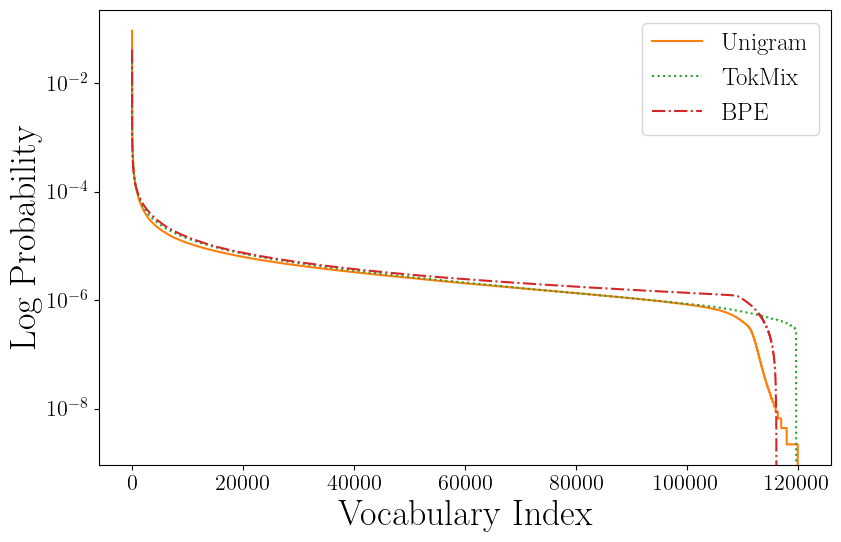

In [11]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(9, 6))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_dist_arrays[tokenization]['All'])[::-1]
    ax.plot(sorted_data,c=colors[t_idx],ls=line_styles[t_idx], label=name_map[tokenization])
ax.set_yscale('log')
ax.set_ylabel('Log Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_log_pdf_20L.pdf"), dpi=300)
plt.show()

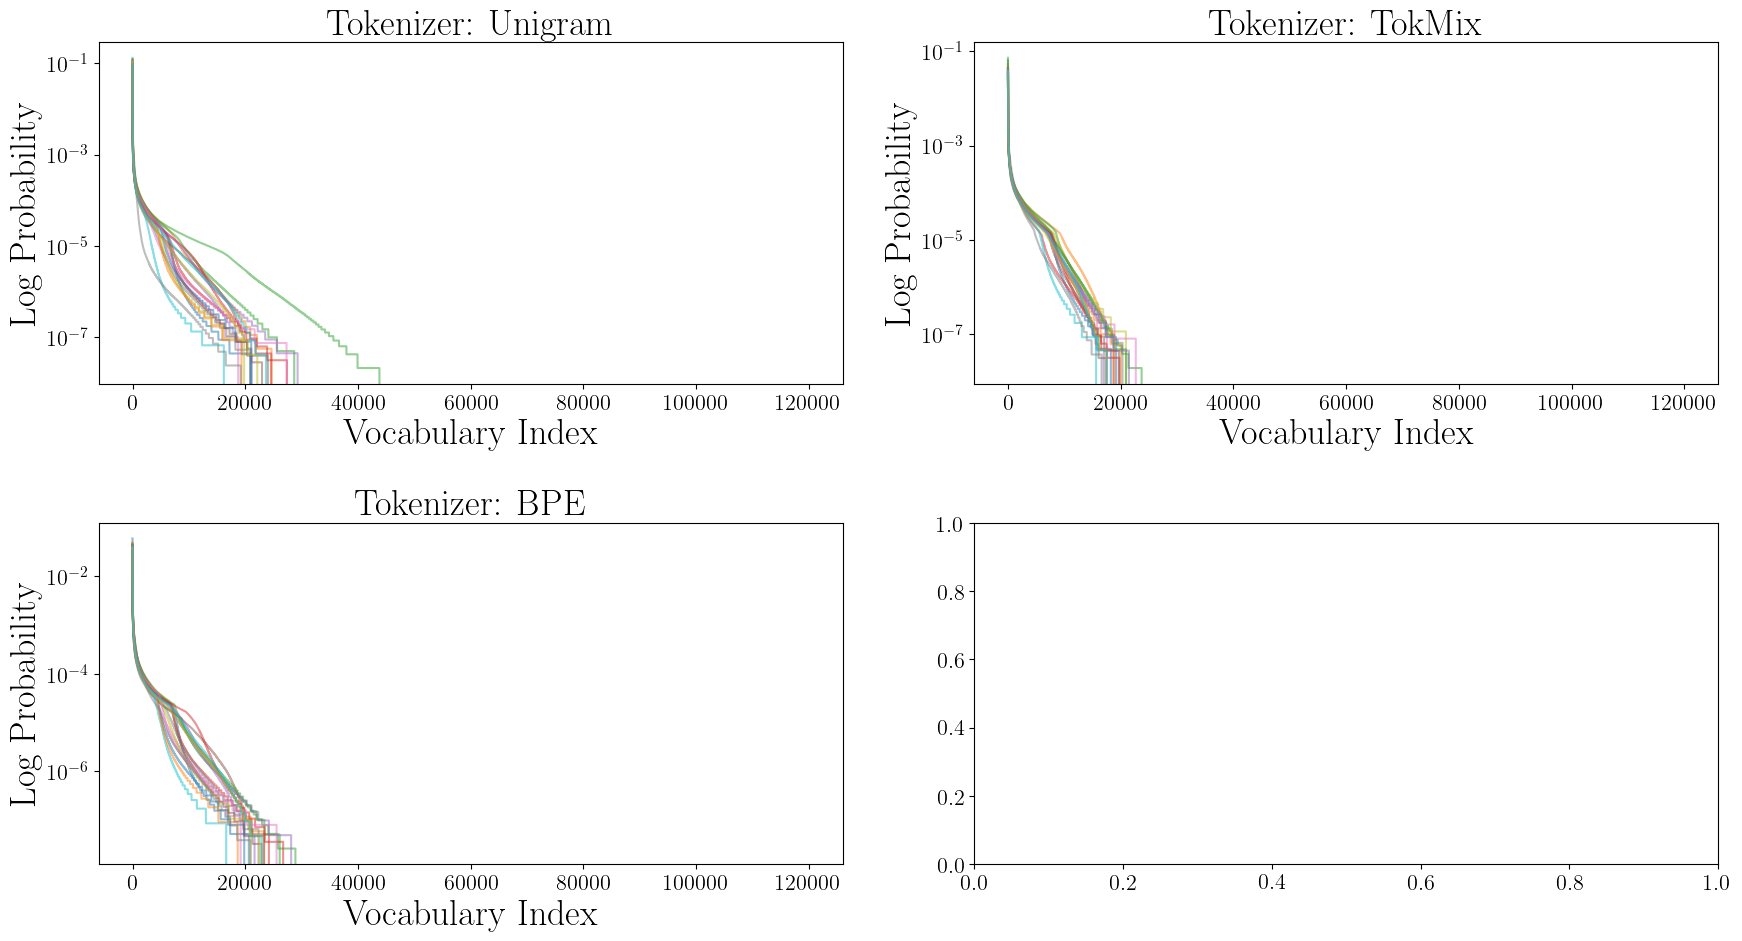

In [12]:
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
axes = axes.ravel()
for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    for lang in languages:
        sorted_lang_data = np.sort(vocab_dist_arrays[tokenization][lang])[::-1]
        axes[t_idx].plot(sorted_lang_data, label=lang, alpha=0.5)
        axes[t_idx].set_ylabel('Log Probability')
        axes[t_idx].set_xlabel('Vocabulary Index')
        axes[t_idx].legend()
    axes[t_idx].set_yscale('log')
    axes[t_idx].set_title(f"Tokenizer: {name_map[tokenization]}")
    #axes[t_idx].legend()
    axes[t_idx].get_legend().remove()

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_log_pdf_each_language_20L.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Function

<Figure size 640x480 with 0 Axes>

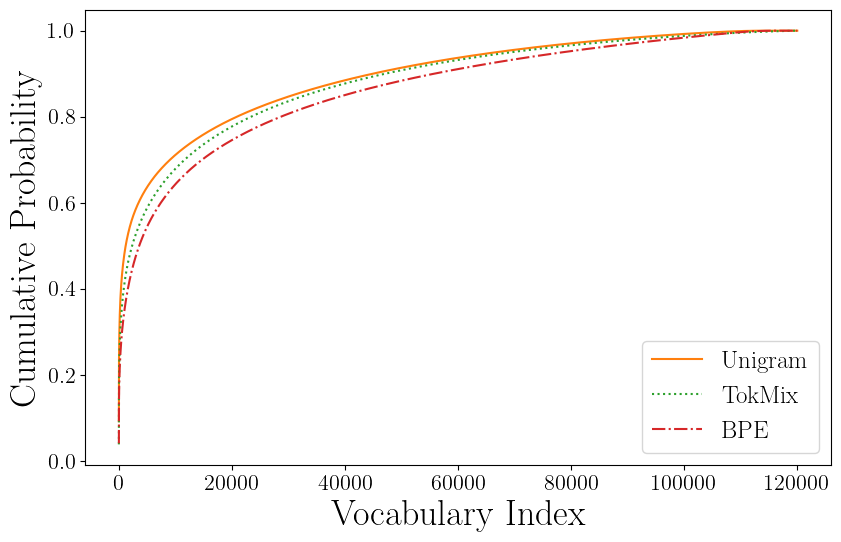

In [13]:
line_styles=['-', ':', '-.', '--']
colors= ["C1", "C2", "C3", "C4"]
plt.figure()
f, ax = plt.subplots(figsize=(9, 6))
for t_idx, tokenization in enumerate(tokenization_types):
    sorted_data = np.sort(vocab_dist_arrays[tokenization]['All'])[::-1]
    cdf = np.cumsum(sorted_data)
    ax.plot(cdf,c=colors[t_idx],ls=line_styles[t_idx], label=name_map[tokenization])

ax.set_ylabel('Cumulative Probability')
ax.set_xlabel('Vocabulary Index')
ax.legend()


plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf_20L.pdf"), dpi=300)
plt.show()

## Cumulative Distribution Functions (for specific languages)

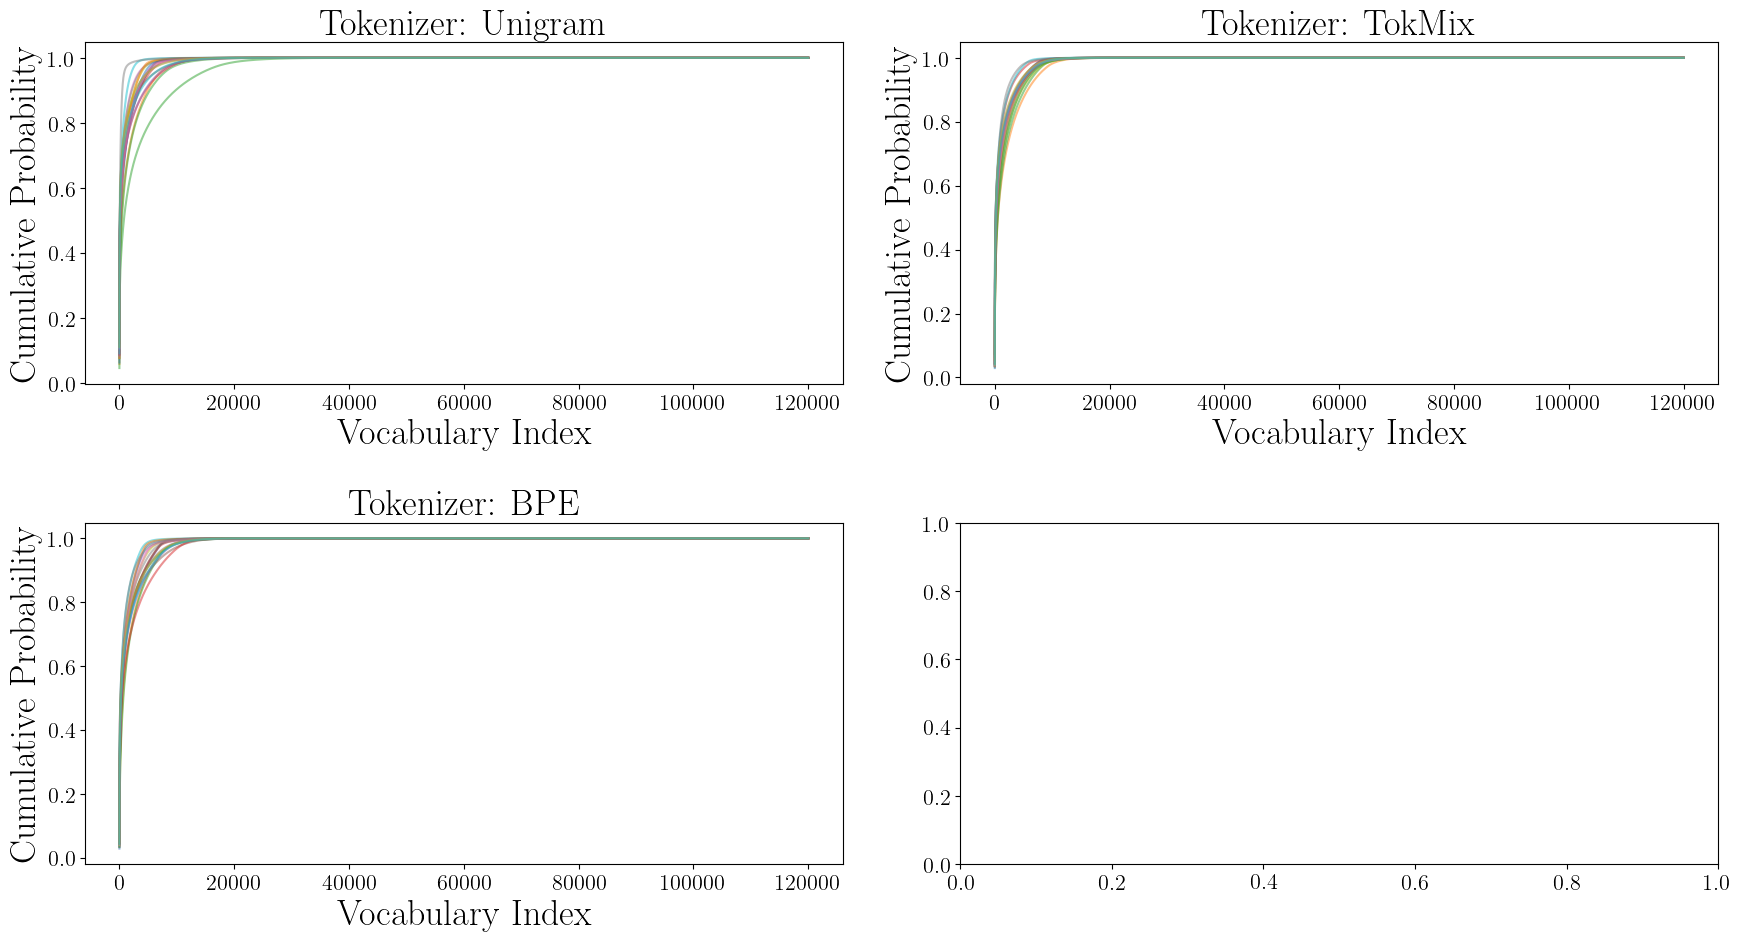

In [14]:
fig, axes = plt.subplots(2, 2,figsize=(18, 10))
axes = axes.ravel()
for t_idx, tokenization in enumerate(tokenization_types):
    ax = axes[t_idx]
    for lang in languages:
        sorted_lang_data = np.sort(vocab_dist_arrays[tokenization][lang])[::-1]
        axes[t_idx].plot(np.cumsum(sorted_lang_data), label=lang, alpha=0.5)
        axes[t_idx].set_ylabel('Cumulative Probability')
        axes[t_idx].set_xlabel('Vocabulary Index')
        axes[t_idx].legend()
    axes[t_idx].set_title(f"Tokenizer: {name_map[tokenization]}")
    #axes[t_idx].legend()
    axes[t_idx].get_legend().remove()

    
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "tokenizers_cdf_each_language_20L.pdf"), dpi=300)
plt.show()

# Vocab statistics

## Average Ranks of Vocabulary Units (Vocab allocation)

In [15]:
def compute_rank_average(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    return r_e

def compute_rank_std(probabilites):
    sorted_probabilities = np.sort(probabilites)[::-1]
    r_e = np.sum(sorted_probabilities * np.arange(len(probabilites)))
    r_e2 = np.sum(sorted_probabilities * (np.arange(len(probabilites)) ** 2.))
    
    return np.sqrt(r_e2 - (r_e ** 2.))
    

In [16]:
for tokenization in tokenization_types:
    rank_est = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 
    rank_std = {'task': 'allocation', 'metric': 'Avg. Rank', 'tokenizer': tokenization} 

    for lang, probabilities in vocab_dist_arrays[tokenization].items():
        rank_est[lang] = compute_rank_average(probabilities)
        rank_std[lang] = compute_rank_std(probabilities)
        
    rank_est['All'] /= len(languages)
    rank_std['All'] /= np.sqrt(len(languages))

    in_lang_results = in_lang_results.append(rank_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(rank_std, ignore_index=True)

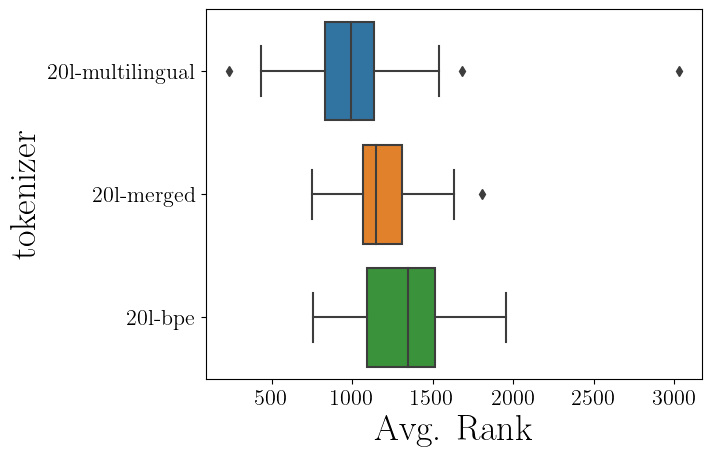

In [17]:
boxplot_across_languages(in_lang_results, 'Avg. Rank', languages)

## Comparision of token numbers

In [18]:
for tokenization in tokenization_types:
    cpt_est = {'task': 'allocation', 'metric': 'CPT', 'tokenizer': tokenization} 
    cpt_std = {'task': 'allocation', 'metric': 'CPT', 'tokenizer': tokenization} 
    
    all_corpora_size = 0
    for lang in languages:
        cpt_est[lang] = corpus_sizes[lang][f"alpha{alpha}"] / np.sum(list(vocab_frequencies[tokenization][lang].values())) 
        cpt_std[lang] = 0
        all_corpora_size += corpus_sizes[lang][f"alpha{alpha}"] 
        
    cpt_est['All'] = all_corpora_size /  np.sum(list(vocab_frequencies[tokenization]['All'].values()))
    cpt_std['All'] = 0
        
    in_lang_results = in_lang_results.append(cpt_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(cpt_std, ignore_index=True)

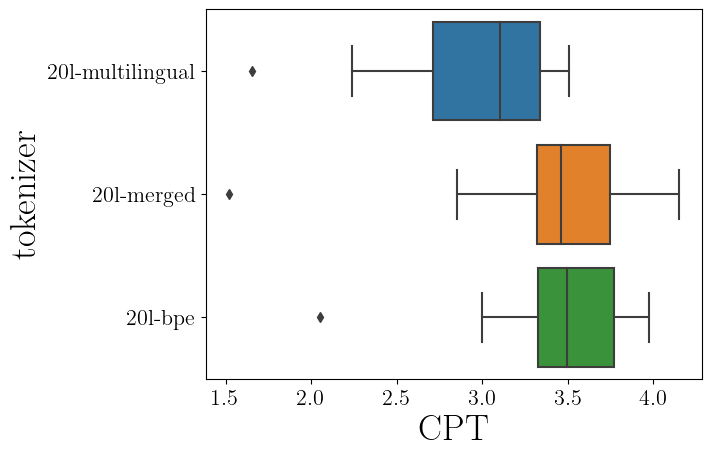

In [19]:
boxplot_across_languages(in_lang_results, 'CPT', languages)

# Results for LMs

## Original task performance (MRR / BPC)

In [20]:
mlm_results = {tok_type: get_mlm_results(tok_type, alpha, N_vocab, languages) for 
                      tok_type in tokenization_types}

Mean reciprocal rank

In [21]:


for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'MRR', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['mrr'])
    mrr_est['All'] = np.average(list(mlm_results[tokenization]['mrr'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['All'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

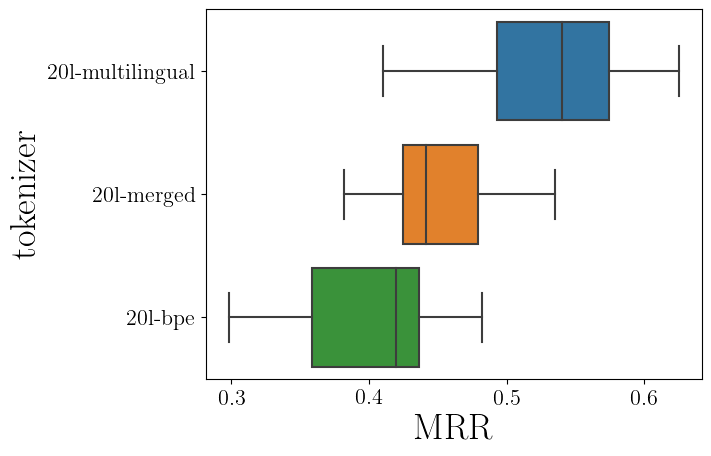

In [22]:
boxplot_across_languages(in_lang_results, 'MRR', languages)

Bits per character

In [23]:
for tokenization in tokenization_types:
    mrr_est = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    mrr_std = {'task': 'LM', 'metric': 'BPC', 'tokenizer': tokenization} 
    
    mrr_est.update(mlm_results[tokenization]['bpc'])
    mrr_est['All'] = np.average(list(mlm_results[tokenization]['bpc'].values()))
    
    for lang in languages:
        mrr_std[lang] = 0.
    mrr_std['All'] = 0.

    in_lang_results = in_lang_results.append(mrr_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(mrr_std, ignore_index=True)

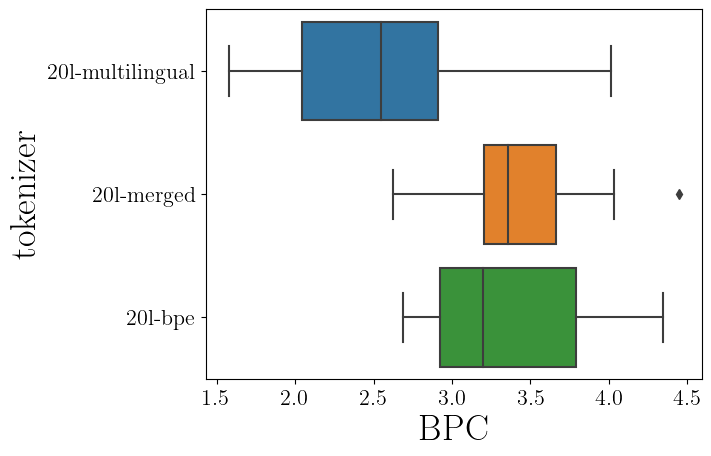

In [24]:
boxplot_across_languages(in_lang_results, 'BPC', languages)

## Down-stream task performance (POS / NER / ...)

POS

In [25]:
pos_results = dict()
pos_stds = dict()

metrics = ('accuracy','f1-macro')
for tok_type in tokenization_types:
    pos_results[tok_type], pos_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages_pos,
                                                                        'POS',ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1230,1231, 1232))
    pos_results[tok_type] = {m : {lang: pos_results[tok_type][m][lang][lang] for lang in languages_pos}
                             for m in metrics}
    pos_stds[tok_type] = {m: {lang: pos_stds[tok_type][m][lang][lang] for lang in languages_pos}
                          for m in metrics}

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/tr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/de/accuracy_evaluation/es/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/tr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/es/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/tr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/el/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/tr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/accuracy_evaluation/es/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenizatio

/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/ar/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/tr/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/zh/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/el/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_1231/fr/f1-macro_evaluation/es/f1-macro_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/POS_PROBE/20l-bpe-tokenizatio

In [26]:
for tokenization in tokenization_types:
    pos_est = {'task': 'POS', 'metric': 'F1', 'tokenizer': tokenization} 
    pos_std = {'task': 'POS', 'metric': 'F1', 'tokenizer': tokenization} 
    
    pos_est.update(pos_results[tokenization]['f1-macro'])
    pos_est['All'] = np.average(list(pos_results[tokenization]['f1-macro'].values()))
    
    pos_std.update(pos_stds[tokenization]['f1-macro'])
    pos_std['All'] = np.average(list(pos_stds[tokenization]['f1-macro'].values()))
    

    in_lang_results = in_lang_results.append(pos_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(pos_std, ignore_index=True)

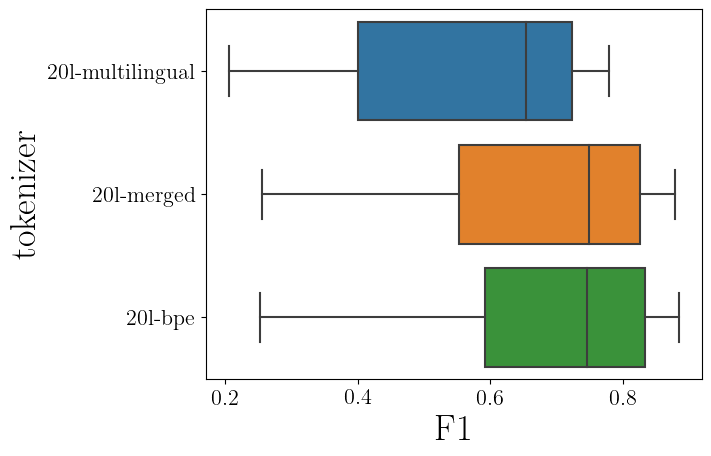

In [27]:
boxplot_across_languages(in_lang_results, 'F1', languages_pos, task='POS')

NER

In [28]:
ner_results = dict()
ner_stds = dict()

metrics = ('f1-seqeval','f1-macro')
for tok_type in tokenization_types:
    ner_results[tok_type], ner_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages,
                                                                        'NER', ft_type=ft_type, metrics=metrics,
                                                                        seeds=(1230,1231, 1232))
    ner_results[tok_type] = {m : {lang: ner_results[tok_type][m][lang][lang] for lang in languages}
                             for m in metrics}
    ner_stds[tok_type] = {m: {lang: ner_stds[tok_type][m][lang][lang] for lang in languages}
                          for m in metrics}

In [29]:
for tokenization in tokenization_types:
    ner_est = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    ner_std = {'task': 'NER', 'metric': 'F1', 'tokenizer': tokenization} 
    
    ner_est.update(ner_results[tokenization]['f1-macro'])
    ner_est['All'] = np.average(list(ner_results[tokenization]['f1-macro'].values()))
    
    ner_std.update(ner_stds[tokenization]['f1-macro'])
    ner_std['All'] = np.average(list(ner_stds[tokenization]['f1-macro'].values()))
    

    in_lang_results = in_lang_results.append(ner_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(ner_std, ignore_index=True)

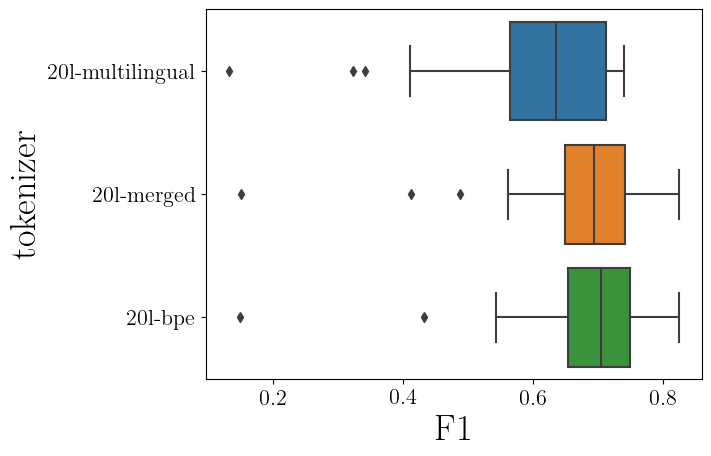

In [30]:
boxplot_across_languages(in_lang_results, 'F1', languages, task='NER')

## UD

In [31]:
ud_results = dict()
ud_stds = dict()

metrics = ('accuracy','f1')
for tok_type in tokenization_types:
    ud_results[tok_type], ud_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages_pos,
                                                                        'UD',ft_type=ft_type, metrics=metrics,
                                                                        seeds=(2000, 2001, 2002))
    ud_results[tok_type] = {m : {lang: ud_results[tok_type][m][lang][lang] for lang in languages_pos}
                             for m in metrics}
    ud_stds[tok_type] = {m: {lang: ud_stds[tok_type][m][lang][lang] for lang in languages_pos}
                          for m in metrics}

/home/limisiewicz/my-luster/entangled-in-scripts/models/UD_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_2001/ur/accuracy_evaluation/ar/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/UD_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_2001/ur/accuracy_evaluation/tr/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/UD_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_2001/ur/accuracy_evaluation/zh/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/UD_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_2001/ur/accuracy_evaluation/el/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/UD_PROBE/20l-merged-tokenization/alpha-0.25_alpha-train-0.25_N-120000_2001/ur/accuracy_evaluation/es/accuracy_all.txt not found.
/home/limisiewicz/my-luster/entangled-in-scripts/models/UD_PROBE/20l-merged

In [32]:
for tokenization in tokenization_types:
    ud_est = {'task': 'UD', 'metric': 'F1', 'tokenizer': tokenization} 
    ud_std = {'task': 'UD', 'metric': 'F1', 'tokenizer': tokenization} 
    
    ud_est.update(ud_results[tokenization]['f1'])
    ud_est['All'] = np.average(list(ud_results[tokenization]['f1'].values()))
    
    ud_std.update(ud_stds[tokenization]['f1'])
    ud_std['All'] = np.average(list(ud_stds[tokenization]['f1'].values()))
    

    in_lang_results = in_lang_results.append(ud_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(ud_std, ignore_index=True)

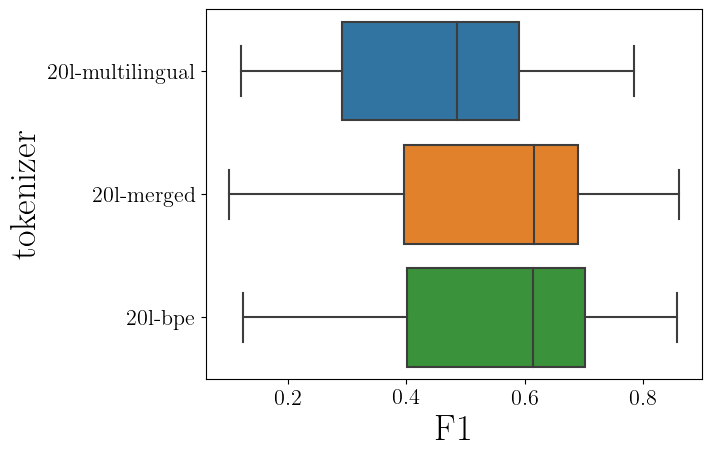

In [33]:
boxplot_across_languages(in_lang_results, 'F1', languages_pos, task='UD')

## XNLI

In [34]:
xnli_results = dict()
xnli_stds = dict()

metrics = ('accuracy',)
for tok_type in tokenization_types:
    xnli_results[tok_type], xnli_stds[tok_type] =  get_downstream_results(tok_type, alpha, N_vocab, languages_xnli,
                                                                        'XNLI', ft_type=ft_type, metrics=metrics,
                                                                        seeds=(2000,2001,2002))
    xnli_results[tok_type] = {m : {lang: xnli_results[tok_type][m][lang][lang] for lang in languages_xnli}
                             for m in metrics}
    xnli_stds[tok_type] = {m: {lang: xnli_stds[tok_type][m][lang][lang] for lang in languages_xnli}
                          for m in metrics}

In [35]:
for tokenization in tokenization_types:
    xnli_est = {'task': 'XNLI', 'metric': 'Acc', 'tokenizer': tokenization} 
    xnli_std = {'task': 'XNLI', 'metric': 'Acc', 'tokenizer': tokenization} 
    
    xnli_est.update(xnli_results[tokenization]['accuracy'])
    xnli_est['All'] = np.average(list(xnli_results[tokenization]['accuracy'].values()))
    
    xnli_std.update(xnli_stds[tokenization]['accuracy'])
    xnli_std['All'] = np.average(list(xnli_stds[tokenization]['accuracy'].values()))
    

    in_lang_results = in_lang_results.append(xnli_est, ignore_index=True)
    in_lang_stds = in_lang_stds.append(xnli_std, ignore_index=True)

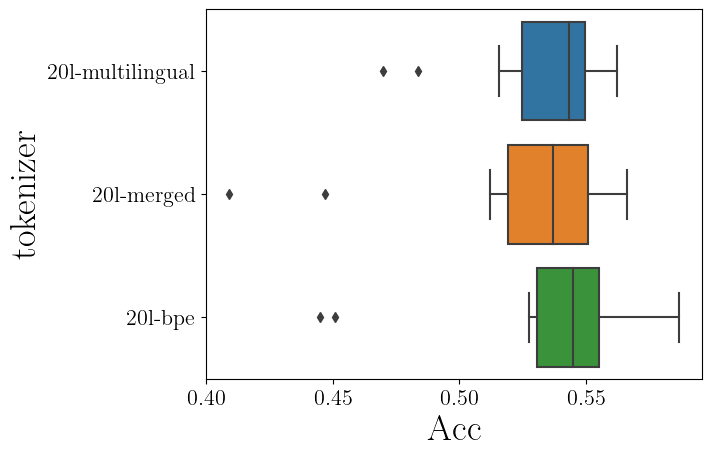

In [36]:
boxplot_across_languages(in_lang_results, 'Acc', languages, task='XNLI')

# Correlation Analysis

In [37]:
in_lang_results.sort_values(["task", "metric"])

,task,metric,tokenizer,ar,tr,zh,el,es,en,sw,...,te,th,ru,bg,he,ka,vi,fr,de,All
9,LM,BPC,20l-multilingual,2.809116,3.162762,3.632192,1.979857,2.226074,2.676476,1.842017,...,2.434927,4.014413,2.340380,2.882723,2.587668,3.000815,1.574261,2.053322,2.693071,2.590545
10,LM,BPC,20l-merged,4.450555,3.671978,3.314127,2.705757,3.153287,3.359716,3.387822,...,3.221119,4.032404,2.681147,3.369539,3.357312,3.887381,2.625541,3.061141,3.297485,3.390889
11,LM,BPC,20l-bpe,4.210008,3.684293,4.344548,2.689354,3.070970,3.199383,2.726139,...,2.925789,4.052939,2.917984,3.429987,4.144439,3.049490,2.726229,2.909078,NaN,NaN
6,LM,MRR,20l-multilingual,0.480395,0.443326,0.429120,0.581047,0.569934,0.547350,0.599766,...,0.524826,0.410332,0.539339,0.505917,0.546358,0.496732,0.625554,0.573071,0.540647,0.526205
7,LM,MRR,20l-merged,0.382128,0.391262,0.432430,0.534972,0.484906,0.481295,0.430163,...,0.437704,0.407651,0.511561,0.473538,0.431616,0.442399,0.472117,0.497208,0.478364,0.447828
8,LM,MRR,20l-bpe,0.341168,0.360623,0.297909,0.482371,0.443228,0.416950,0.469430,...,0.422270,0.344799,0.435141,0.414184,0.342054,0.413597,0.438418,0.442778,0.433308,0.405310
15,NER,F1,20l-multilingual,0.604266,0.729521,0.323911,0.673054,0.711218,0.659490,0.410981,...,0.132398,0.342690,0.702025,0.728598,0.544635,0.581160,0.739704,0.713345,0.664587,0.588737
16,NER,F1,20l-merged,0.759249,0.754370,0.562263,0.688509,0.735927,0.693491,0.487933,...,0.150958,0.412891,0.713594,0.752222,0.644313,0.704860,0.785041,0.737421,0.694907,0.653796
17,NER,F1,20l-bpe,0.759793,0.776309,0.544905,0.704940,0.746250,0.704000,0.543197,...,0.149878,0.433099,0.726283,0.759294,0.643901,0.722938,0.785824,0.744259,0.705800,0.663093
12,POS,F1,20l-multilingual,0.500042,0.434379,0.216079,0.436392,0.724294,0.766762,NaN,...,0.304555,NaN,0.748451,0.779034,0.679114,NaN,0.399980,0.726579,0.706783,0.540066


In [38]:
in_lang_stds

,task,metric,tokenizer,ar,tr,zh,el,es,en,sw,...,te,th,ru,bg,he,ka,vi,fr,de,All
0,allocation,Avg. Rank,20l-multilingual,1667.166681,2527.552090,4841.391720,1924.037149,1855.175126,2270.220247,1403.781022,...,1374.335220,2795.650568,2504.984832,2525.790911,1746.445075,1878.782818,708.308194,1907.704961,2285.714831,4977.256311
1,allocation,Avg. Rank,20l-merged,1882.782973,2653.586031,2408.692084,1557.712389,1901.979929,2133.139005,2094.614573,...,2073.198315,2265.966073,1976.280552,2004.510863,1887.457335,2027.128878,1318.327918,1893.399453,2006.038186,5190.112795
2,allocation,Avg. Rank,20l-bpe,2018.529485,2524.094261,2458.814662,2138.067500,2384.066940,2804.831095,1691.346037,...,1412.717259,2620.753325,3009.851559,2642.349316,2029.726396,1818.351281,1532.506251,2428.945402,2579.632063,5674.641618
3,allocation,CPT,20l-multilingual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,allocation,CPT,20l-merged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,allocation,CPT,20l-bpe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,LM,MRR,20l-multilingual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,LM,MRR,20l-merged,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,LM,MRR,20l-bpe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,LM,BPC,20l-multilingual,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [39]:
def format_text(mean, std=0. ,mult=1., dec=1, with_stds=False):
    if mean != mean:
        return "-"

    mean = round(mean * mult, dec)
    std = round(std * mult, dec)
    
    if dec == 0:
        mean = int(mean)
        std = int(mean)
        
    if with_stds:
        return f"{mean} $_{{\pm{std}}}$"
    else:
        return f"{mean}"



def preprocess_table(table):
    table['metric'] = [r[1]['task'] if r[1]['task']  not in ('allocation', 'LM')
              else r[1]['metric'] for r in table.iterrows()]
    table= table.drop(columns=['task'])
    
    table = table[table['metric']  != 'BPC']
    table = table.replace({'tokenizer': name_map})
    table['tokenizer'] = pd.Categorical(table.tokenizer, categories=['Unigram','BPE','TokMix'],
                                        ordered=True)
    
    table['metric'] = pd.Categorical(table.metric, categories=['Avg. Rank', 'CPT', 'MRR', 'NER','POS','UD', 'XNLI',],
                            ordered=True)
    
    table.set_index(['metric', 'tokenizer'], inplace=True)
    table.sort_values(['metric', 'tokenizer'], inplace=True)
    return table


def textify_results(res, stds):
    for i, row in res.iterrows():
        if i[0] == 'Avg. Rank':
            res.loc[i] = [format_text(v, dec=0) for v in row]
        elif i[0] == 'CPT':
            res.loc[i] = [format_text(v, dec=2) for v in row]
        elif i[0] == 'MRR':
            res.loc[i] = [format_text(v, mult=100.) for v in row]
        else:
            res.loc[i] = [format_text(v, std=s, mult=100., with_stds=True) for v, s in zip(row, stds.loc[i])]

    return res
    

In [40]:
tab_res = preprocess_table(in_lang_results)
tab_std = preprocess_table(in_lang_stds)

out_in_lang = textify_results(tab_res, tab_std)
out_in_lang

ar                tr                zh  \
metric    tokenizer                                                         
Avg. Rank Unigram                 998              1542              3033   
          BPE                    1378              1737              1435   
          TokMix                 1141              1805              1632   
CPT       Unigram                2.71              3.45              1.65   
          BPE                    3.22              3.65              2.05   
          TokMix                 3.06              3.79              1.52   
MRR       Unigram                48.0              44.3              42.9   
          BPE                    34.1              36.1              29.8   
          TokMix                 38.2              39.1              43.2   
NER       Unigram    60.4 $_{\pm0.1}$  73.0 $_{\pm0.1}$  32.4 $_{\pm0.1}$   
          BPE        76.0 $_{\pm0.1}$  77.6 $_{\pm0.1}$  54.5 $_{\pm0.1}$   
          TokMix     75.9 $_{\pm0.1}$  75.4 $_{\pm0.0}$  56.2 $_{\pm0.1}$   
POS       Unigram    50.0 $_{\pm0.1}$  43.4 $_{\pm0.2}$  21.6 $_{\pm0.0}$   
          BPE        66.2 $_{\pm0.0}$  51.7 $_{\pm0.1}$  59.2 $_{\pm0.1}$   
          TokMix     65.9 $_{\pm0.1}$  51.2 $_{\pm0.1}$  55.3 $_{\pm0.1}$   
UD        Unigram    12.0 $_{\pm0.0}$  56.9 $_{\pm0.2}$  15.3 $_{\pm0.1}$   
          BPE        13.3 $_{\pm0.5}$  62.7 $_{\pm1.2}$  56.1 $_{\pm0.2}$   
          TokMix     10.0 $_{\pm0.0}$  64.6 $_{\pm1.0}$  54.0 $_{\pm0.1}$   
XNLI      Unigram    51.6 $_{\pm0.3}$  53.4 $_{\pm0.2}$  48.4 $_{\pm0.5}$   
          BPE        52.7 $_{\pm0.5}$  54.5 $_{\pm0.3}$  45.1 $_{\pm0.4}$   
          TokMix     51.9 $_{\pm0.3}$  53.7 $_{\pm0.2}$  40.9 $_{\pm0.6}$   

                                   el                es                en  \
metric    tokenizer                                                         
Avg. Rank Unigram                1023               866              1006   
          BPE                    1322              1374              1508   
          TokMix                  849              1031              1178   
CPT       Unigram                2.93              3.31              3.43   
          BPE                    3.44              3.96              3.98   
          TokMix                 3.13              3.73              3.84   
MRR       Unigram                58.1              57.0              54.7   
          BPE                    48.2              44.3              41.7   
          TokMix                 53.5              48.5              48.1   
NER       Unigram    67.3 $_{\pm0.1}$  71.1 $_{\pm0.0}$  65.9 $_{\pm0.1}$   
          BPE        70.5 $_{\pm0.1}$  74.6 $_{\pm0.0}$  70.4 $_{\pm0.1}$   
          TokMix     68.9 $_{\pm0.1}$  73.6 $_{\pm0.1}$  69.3 $_{\pm0.0}$   
POS       Unigram    43.6 $_{\pm0.2}$  72.4 $_{\pm0.2}$  76.7 $_{\pm0.1}$   
          BPE        64.8 $_{\pm0.1}$  82.2 $_{\pm0.1}$  87.4 $_{\pm0.1}$   
          TokMix     60.7 $_{\pm0.1}$  81.7 $_{\pm0.2}$  86.6 $_{\pm0.1}$   
UD        Unigram    52.4 $_{\pm0.1}$  67.3 $_{\pm0.1}$  61.6 $_{\pm0.1}$   
          BPE        67.7 $_{\pm0.4}$  77.1 $_{\pm0.4}$  70.2 $_{\pm0.3}$   
          TokMix     67.5 $_{\pm0.5}$  76.9 $_{\pm0.2}$  69.0 $_{\pm0.1}$   
XNLI      Unigram    54.8 $_{\pm0.2}$  55.1 $_{\pm0.4}$  56.2 $_{\pm0.2}$   
          BPE        55.5 $_{\pm0.2}$  55.9 $_{\pm0.2}$  58.7 $_{\pm0.2}$   
          TokMix     53.8 $_{\pm0.3}$  55.2 $_{\pm0.2}$  56.6 $_{\pm0.2}$   

                                   sw                hi                mr  \
metric    tokenizer                                                         
Avg. Rank Unigram                 688               691               821   
          BPE                    1067              1150              1128   
          TokMix                 1263              1153              1471   
CPT       Unigram                3.11               2.7              2.86   
          BPE                

In [41]:
out_in_lang.to_latex(os.path.join(TABLE_DIR,"in_lang_table_20l.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                   caption="Results of evaluation for in language properties and tasks for twenty diverse languages."
                   "We observe significant changes for different tokenization methods.",
                   label="tab:in_lang_table_20l")

## Aggregated table

In [42]:
out_in_lang_avg = tab_res.All.unstack(level=0).reindex(index = ['Unigram','BPE','TokMix'])
out_in_lang_avg

metric,Avg. Rank,CPT,MRR,NER,POS,UD,XNLI
tokenizer,,,,,,,
Unigram,623,2.89,52.6,58.9 $_{\pm0.2}$,54.0 $_{\pm0.4}$,43.7 $_{\pm0.4}$,53.2 $_{\pm0.3}$
BPE,809,3.43,40.5,66.3 $_{\pm0.2}$,67.3 $_{\pm0.4}$,54.5 $_{\pm0.5}$,53.5 $_{\pm0.3}$
TokMix,689,3.23,44.8,65.4 $_{\pm0.3}$,66.5 $_{\pm0.4}$,53.9 $_{\pm0.5}$,52.3 $_{\pm0.3}$


In [43]:
out_in_lang_avg.to_latex(os.path.join(TABLE_DIR,"in_lang_avg_20l.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                   caption="Results of evaluation for in language properties and tasks for twenty diverse languages."
                   "We observe significant changes for different tokenization methods.",
                   label="tab:in_lang_avg_20l")

## Pairwaise factor analysis

In [44]:

def format_text_ca(r, p, dec=3):
    r = round(r, dec)
    if p < 0.05 and p >= 0.01:
        return  f"{r}*"
    elif p < 0.01:
        return  f"{r}**"
    else:
        return f"{r}"
    
def textify_results_ca(corr, p_val):
    for i, row in corr.iterrows():
        corr.loc[i] = [format_text_ca(c, p) for c, p in zip(row, p_val.loc[i])]

    return corr

def preprocess_table_correlations(table, normalize=True):
    table['metric'] = [r[1]['task'] if r[1]['task']  not in ('allocation', 'LM')
              else r[1]['metric'] for r in table.iterrows()]
    table= table.drop(columns=['task'])
    
    table = table[table['metric']  != 'BPC']
    table = table.replace({'tokenizer': name_map})
    #table.set_index(['metric'], inplace=True)
    
    # normalizing data by language to account for heterogenity 
    table = pd.melt(table, id_vars=['metric', 'tokenizer'],
                     value_vars=languages, var_name='language').\
                    pivot_table(columns=['metric'], values='value', index=['language', 'tokenizer']).\
                    reset_index()

    if normalize:
        table.loc[:, ~table.columns.isin(['language', 'tokenizer'])] = table.groupby("language",).transform(lambda x: ((x - x.mean()) ),) #/ x.std() ),)
    return table

In [45]:
in_lang_ca = preprocess_table_correlations(in_lang_results)

In [46]:
in_lang_ca

metric,language,tokenizer,Avg. Rank,CPT,MRR,NER,POS,UD,XNLI
0,ar,BPE,205.311724,0.219228,-0.060063,0.052024,0.055194,0.015108,0.006720
1,ar,TokMix,-31.520249,0.066367,-0.019102,0.051480,0.051792,-0.017826,-0.001597
2,ar,Unigram,-173.791476,-0.285596,0.079165,-0.103503,-0.106986,0.002718,-0.005123
3,bg,BPE,256.430638,0.213807,-0.050362,0.012590,0.037838,0.045002,0.010401
4,bg,TokMix,-231.001431,-0.078310,0.008992,0.005517,0.031133,0.023943,-0.007829
5,bg,Unigram,-25.429207,-0.135497,0.041371,-0.018107,-0.068971,-0.068945,-0.002573
6,de,BPE,281.705781,0.191934,-0.050799,0.017369,0.038685,0.042606,0.001065
7,de,TokMix,-119.401241,0.058986,-0.005742,0.006476,0.040770,0.043241,-0.001730
8,de,Unigram,-162.304540,-0.250920,0.056541,-0.023845,-0.079455,-0.085847,0.000665
9,el,BPE,257.798963,0.269515,-0.050426,0.016106,0.084150,0.051570,0.007984


In [47]:
spearman_r = in_lang_ca.corr(method='spearman')
spearman_p = in_lang_ca.corr(method=lambda x, y: spearmanr(x, y)[1])

In [48]:
out_ca_in_lang = textify_results_ca(spearman_r.iloc[1:,:3], spearman_p.iloc[1:,:3])
out_ca_in_lang

metric,Avg. Rank,CPT,MRR
metric,,,
CPT,0.79**,1.0,-0.913**
MRR,-0.723**,-0.913**,1.0
NER,0.394**,0.657**,-0.745**
POS,0.32*,0.724**,-0.754**
UD,0.266,0.675**,-0.695**
XNLI,0.56**,0.388*,-0.437**


In [49]:
out_ca_in_lang.to_latex(os.path.join(TABLE_DIR,"corr_in_lang_20l.tex"), index=True,multirow=True,
                          longtable=False, escape=False, encoding="UTF-8",
                        caption="Correlations between task performance metrics and tokenizer measures."
                         "Stars denote statistical significance: (* coresponeds to $p<0.05$ and ** to $p<0.01$).",
                        label="tab:corr_in_lang_20l")

In [50]:
#in_lang_ca = in_lang_ca[in_lang_ca["language_"] != 'zh']

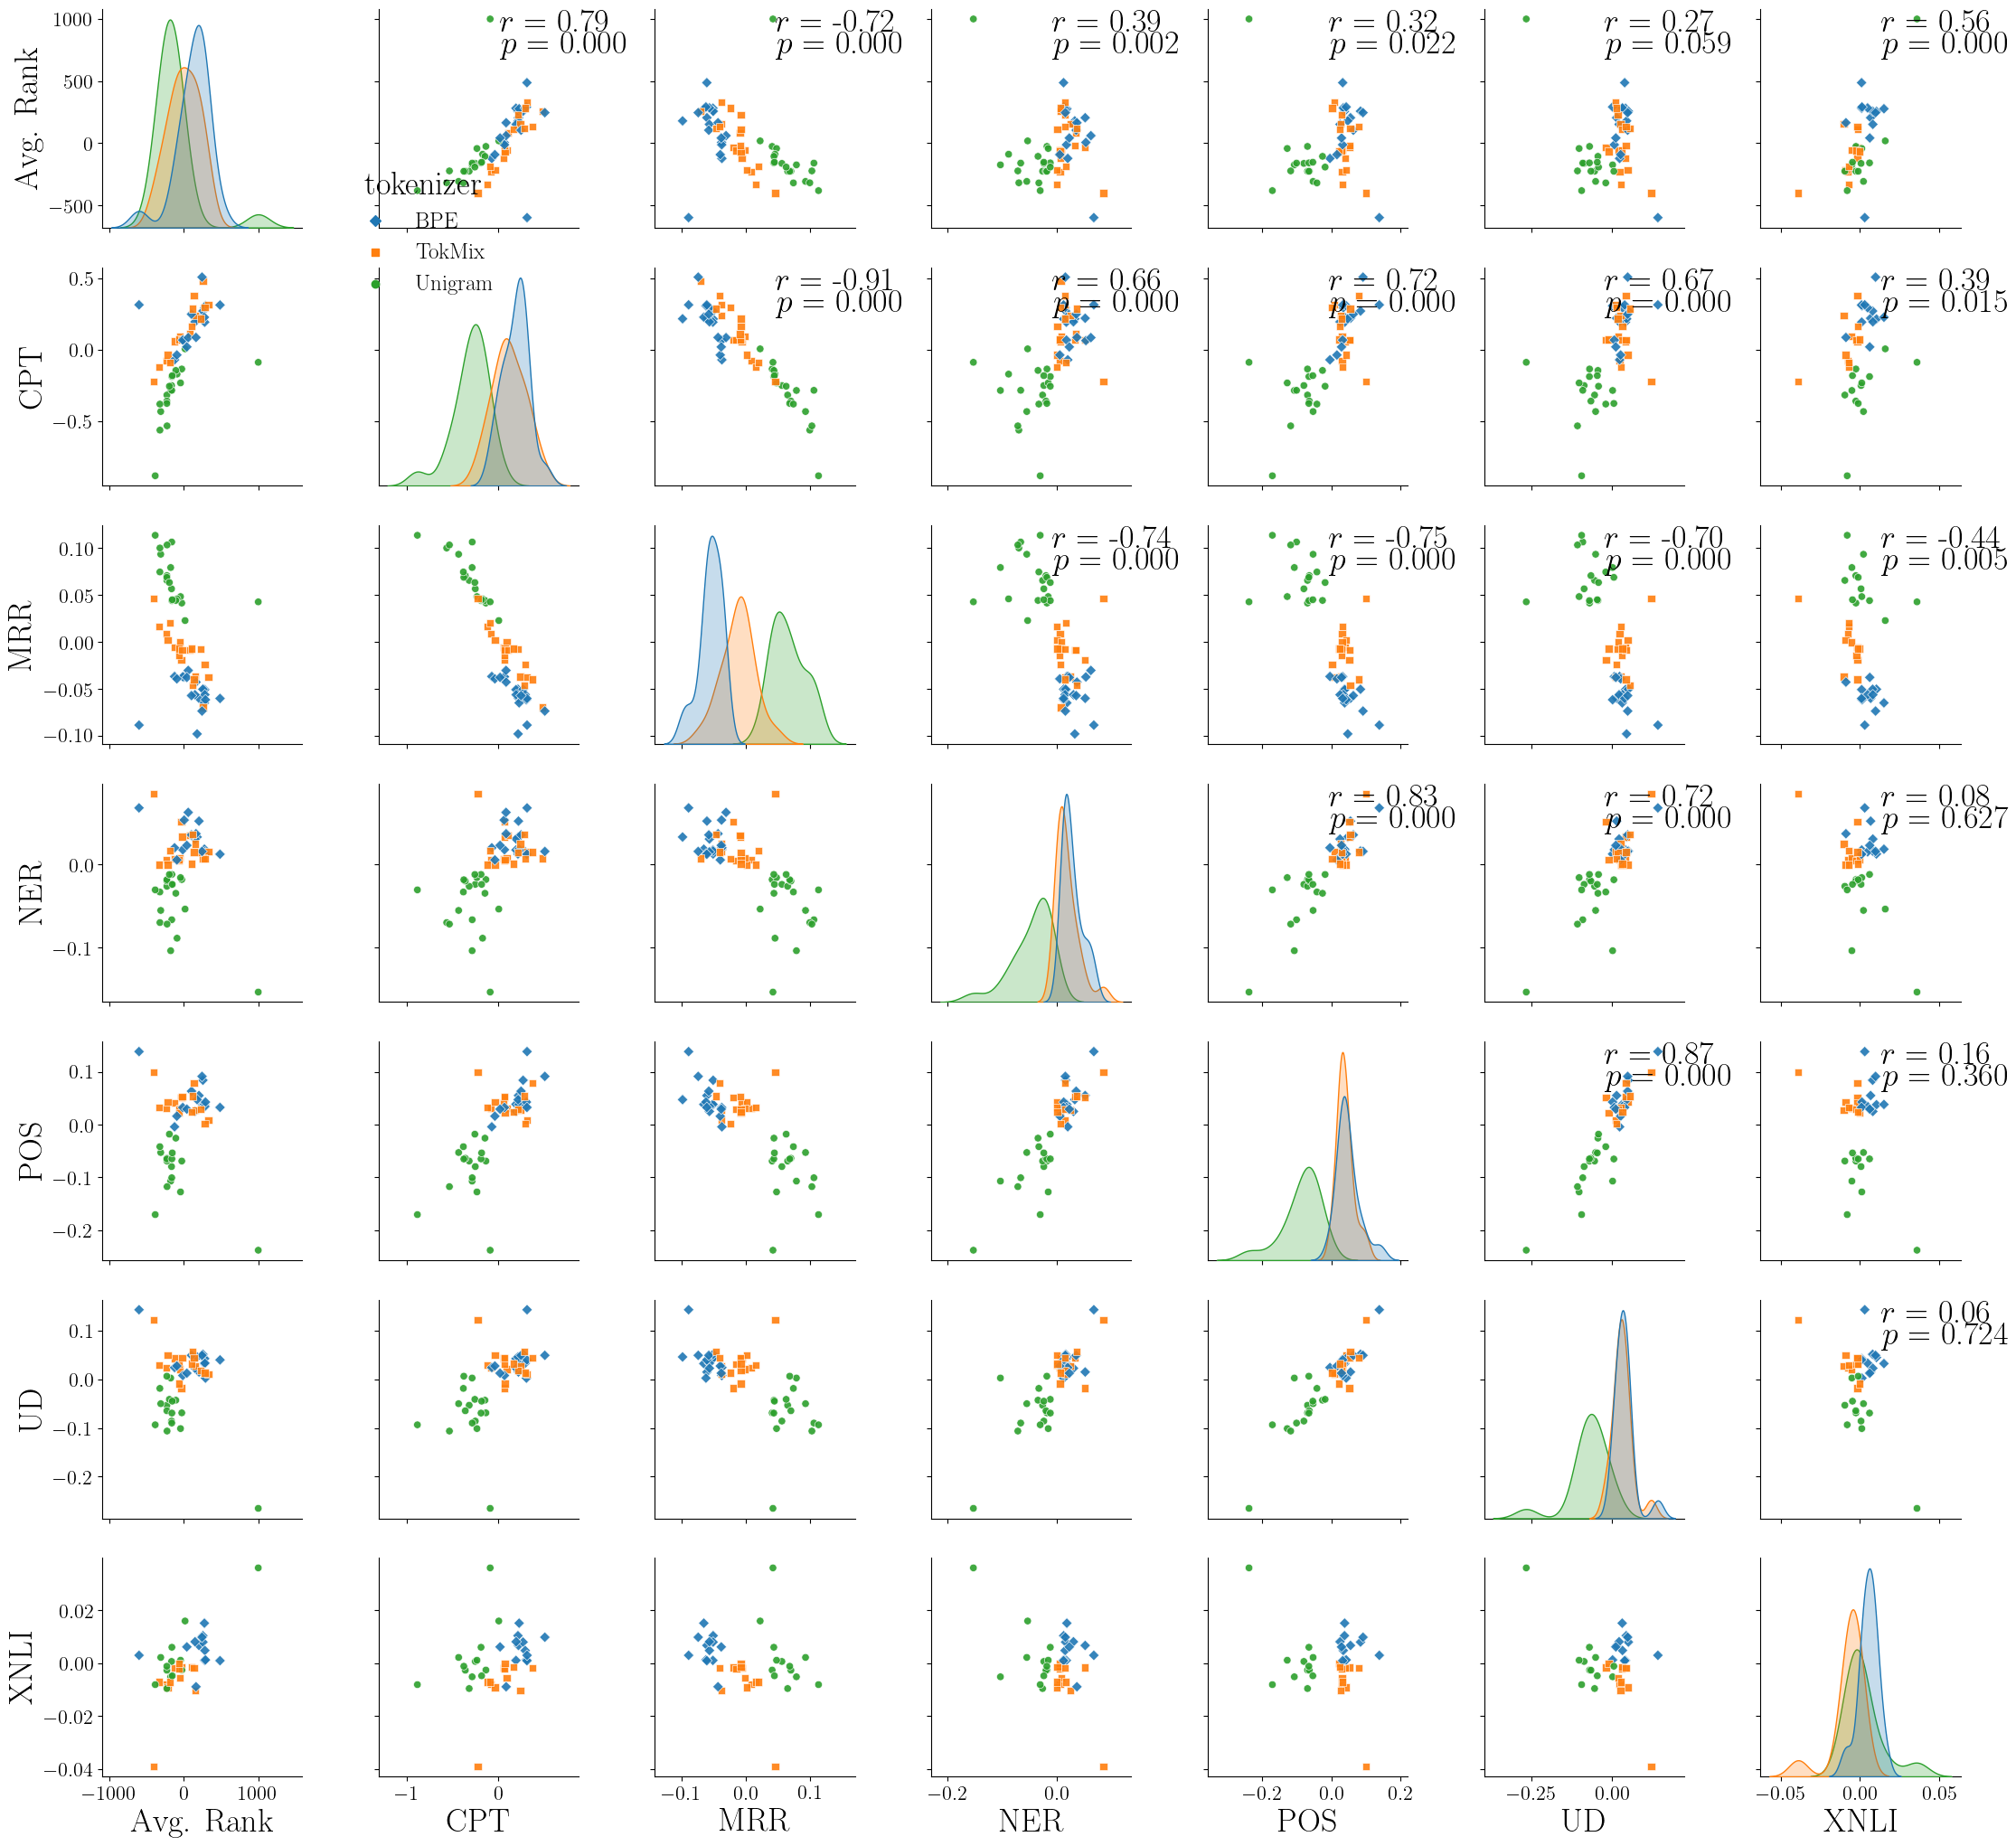

In [51]:
# spearman_r = in_lang_ca.corr(method='spearman').to_numpy()
# spearman_p = in_lang_ca.corr(method=lambda x, y: spearmanr(x, y)[1]).to_numpy()

#plt.figure(figsize=(3.5,3.5))
plot1 = sns.pairplot(in_lang_ca, hue="tokenizer",
                     markers=['D','s', 'o', 'p', 'X'],
                     plot_kws={'alpha': 0.9},
                    size=3)

plot1._legend.set_bbox_to_anchor((.25, 0.85))
# plt.legend(loc='center right', title='Type')
plot1.map
axes = plot1.axes
for i in range(len(in_lang_ca.columns) - 3):
    for j in range(i+1,len(in_lang_ca.columns)-2):
        ax = axes[i][j]
        r = spearman_r.to_numpy()[i,j]
        p = spearman_p.to_numpy()[i,j]
        ax.annotate(r"$r$ = {:.2f}".format(r), xy=(.6, .9), xycoords=ax.transAxes)
        ax.annotate(r"$p$ = {:.3f}".format(p), xy=(.6, .8), xycoords=ax.transAxes)
plt.tight_layout()
plt.savefig(os.path.join(FIGURE_DIR, "pair_analysis_20L.pdf"), dpi=300)


In [52]:
in_lang_ca.corr(method='pearson').to_numpy()

array([[ 1.        ,  0.6301679 , -0.5312817 ,  0.00116944,  0.02281821,
        -0.14600912,  0.64751111],
       [ 0.6301679 ,  1.        , -0.9183802 ,  0.56746246,  0.74496588,
         0.58610817,  0.2980264 ],
       [-0.5312817 , -0.9183802 ,  1.        , -0.69555692, -0.77686749,
        -0.65540675, -0.26112885],
       [ 0.00116944,  0.56746246, -0.69555692,  1.        ,  0.86983138,
         0.81524568, -0.44913261],
       [ 0.02281821,  0.74496588, -0.77686749,  0.86983138,  1.        ,
         0.91512836, -0.25107718],
       [-0.14600912,  0.58610817, -0.65540675,  0.81524568,  0.91512836,
         1.        , -0.43586173],
       [ 0.64751111,  0.2980264 , -0.26112885, -0.44913261, -0.25107718,
        -0.43586173,  1.        ]])

In [53]:
in_lang_ca.corr(method=lambda x, y: pearsonr(x, y)[1]).to_numpy()

array([[1.00000000e+00, 6.84512615e-08, 1.25675854e-05, 9.92924561e-01,
        8.73719757e-01, 3.06612748e-01, 8.37279662e-06],
       [6.84512615e-08, 1.00000000e+00, 5.02544078e-25, 2.26829732e-06,
        3.64199325e-10, 6.21599341e-06, 6.53662562e-02],
       [1.25675854e-05, 5.02544078e-25, 1.00000000e+00, 6.92372992e-10,
        2.06626542e-11, 1.79729644e-07, 1.08341811e-01],
       [9.92924561e-01, 2.26829732e-06, 6.92372992e-10, 1.00000000e+00,
        1.19414355e-16, 3.27056784e-13, 4.12901790e-03],
       [8.73719757e-01, 3.64199325e-10, 2.06626542e-11, 1.19414355e-16,
        1.00000000e+00, 5.75490314e-21, 1.39655353e-01],
       [3.06612748e-01, 6.21599341e-06, 1.79729644e-07, 3.27056784e-13,
        5.75490314e-21, 1.00000000e+00, 7.87900197e-03],
       [8.37279662e-06, 6.53662562e-02, 1.08341811e-01, 4.12901790e-03,
        1.39655353e-01, 7.87900197e-03, 1.00000000e+00]])

Saving in language data to tsv

In [56]:
in_lang_ca.to_csv("in_lang_results_20.tsv", sep='\t')

In [54]:
in_lang_ca_org = preprocess_table_correlations(in_lang_results, normalize=False)
in_lang_ca_org

metric,language,tokenizer,Avg. Rank,CPT,MRR,NER,POS,UD,XNLI
0,ar,BPE,1377.603127,3.217769,0.341168,0.759793,0.662222,0.132711,0.527478
1,ar,TokMix,1140.771154,3.064909,0.382128,0.759249,0.658821,0.099777,0.519162
2,ar,Unigram,998.499927,2.712946,0.480395,0.604266,0.500042,0.120321,0.515635
3,bg,BPE,1565.678702,3.491610,0.414184,0.759294,0.885843,0.763279,0.554824
4,bg,TokMix,1078.246633,3.199493,0.473538,0.752222,0.879138,0.742221,0.536593
5,bg,Unigram,1283.818858,3.142306,0.505917,0.728598,0.779034,0.649333,0.541850
6,de,BPE,1530.965738,3.949382,0.433308,0.705800,0.824923,0.614816,0.544844
7,de,TokMix,1129.858715,3.816434,0.478364,0.694907,0.827007,0.615452,0.542049
8,de,Unigram,1086.955417,3.506528,0.540647,0.664587,0.706783,0.486363,0.544444
9,el,BPE,1322.344354,3.437270,0.482371,0.704940,0.648013,0.676680,0.555289


In [ ]:
 x